<h1>Predicting Stock Price Change</h1>
<h3>Goals for this project:</h3>
<ul><li>Train a neural network that can predict the change in stock prices over the span of a day.</li><li>We will use data from <a href="https://www.kaggle.com/minatverma/nse-stocks-data">https://www.kaggle.com/minatverma/nse-stocks-data</a>.</li></ul>

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

<h1>Get the Data</h1>
<ul><li>This dataset describes the national stock exchange (NSE) of India in 2016 and 2017.</li>
<li>Let's load the data, check for dtypes, and check for missing values.</li></ul>

In [2]:
df = pd.read_csv('FINAL_FROM_DF.csv')
df

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
0,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,2017-06-28,202,INE144J01027
1,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,2017-06-28,7353,INE748C01020
2,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,2017-06-28,748,INE470A01017
3,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,2017-06-28,437,INE111B01023
4,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,2017-06-28,1866,INE650K01021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846399,ZOTA,SM,221.00,221.00,214.00,217.00,217.00,220.00,14000,3041550.00,2017-12-29,14,INE358U01012
846400,ZUARI,EQ,562.00,562.00,549.55,550.80,552.00,556.80,105184,58163061.60,2017-12-29,2218,INE840M01016
846401,ZUARIGLOB,EQ,255.50,258.40,252.50,253.25,253.00,254.10,90067,22968100.60,2017-12-29,2001,INE217A01012
846402,ZYDUSWELL,EQ,1038.00,1068.00,1033.00,1043.20,1035.00,1023.10,28601,29938840.10,2017-12-29,1401,INE768C01010


In [3]:
df.shape

(846404, 13)

In [4]:
df.isnull().sum()

SYMBOL            0
SERIES         2457
OPEN              0
HIGH              0
LOW               0
CLOSE             0
LAST              0
PREVCLOSE         0
TOTTRDQTY         0
TOTTRDVAL         0
TIMESTAMP         0
TOTALTRADES       0
ISIN              0
dtype: int64

In [5]:
df = df.fillna('none')

In [6]:
df.dtypes

SYMBOL          object
SERIES          object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
LAST           float64
PREVCLOSE      float64
TOTTRDQTY        int64
TOTTRDVAL      float64
TIMESTAMP       object
TOTALTRADES      int64
ISIN            object
dtype: object

<ul><li>The data types look appropriate, since numerical values are already stored as integers and floats, and categorical values are stored as strings.</li><li>Let us make a new column that is the increase (or decrease) in the stock price over a day.</li><li>We will try to predict this change using the HIGH, LOW, LAST, PREVCLOSE, TOTTRDQTY, TOTTRDVAL, and TOTALTRADES columns.</li></ul>

In [5]:
df['CHANGE'] = df.CLOSE - df.OPEN

<h1>Train the Model</h1>
<ul><li>We will handle our neural network using TensorFlow.</li><li>Let's add a few Dense layers, dropout layers for regularization, and an intermediate batch normalization layer to prevent exploding gradients, since our model will have quite a few dense layers.</li><li>We use the SELU activation function to further manage the size of the gradients.</li></ul>

In [7]:
model = keras.models.Sequential([
    keras.layers.Dense(units=100, activation='selu', input_shape=[7]),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(units=100, activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=50, activation='selu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(units=25, activation='selu'),
    keras.layers.Dense(units=1),
])

model.compile(optimizer = 'adam', loss = 'mse')

<ul><li>We also need to make training and validation sets and rescale the input instances.</li></ul>

In [8]:
df = df[['CHANGE', 'HIGH', 'LOW', 'LAST', 'PREVCLOSE', 'TOTTRDQTY', 'TOTTRDVAL', 'TOTALTRADES']]

df_train = df.sample(frac = 0.8, random_state = 1) # train
df_valid = df.drop(df_train.index) # valid

max_train = df_train.max()
min_train = df_train.min()
df_train = (df_train - min_train) / (max_train - min_train) # min / max scaling

max_valid = df_valid.max()
min_valid = df_valid.min()
df_valid = (df_valid - min_valid) / (max_valid - min_valid) # min / max scaling

X_train = df_train.drop('CHANGE', axis=1) # remove the targets
X_valid = df_valid.drop('CHANGE', axis=1)

y_train = df_train['CHANGE'] # assign the targets
y_valid = df_valid['CHANGE']

<ul><li>We can use an early stopping callback to stop training the model once the training loss consistently decreases for a threshold number of epochs.</li></ul>

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # a change of this much constitutes a decrease in the loss
    patience=20, # number of epochs to wait for
    restore_best_weights=True,)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0)

<ul><li>Here are the training loss and the validation loss.</li></ul>

<Axes: >

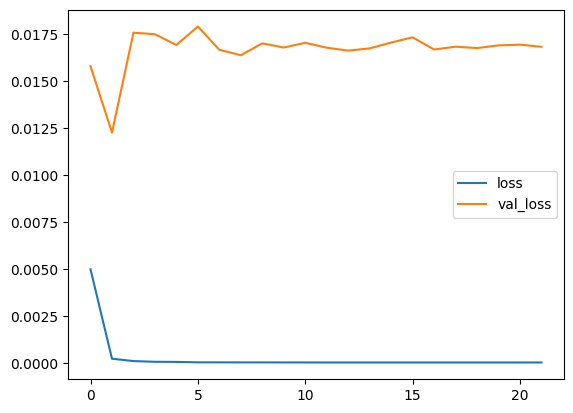

In [10]:
pd.DataFrame(history.history).plot()